---
# Import modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set(rc={'figure.figsize':(9,6)})

___
# Read Data

In [3]:
events_data = pd.read_csv('Stepik Data/event_data_train.csv')
submissions_data = pd.read_csv('Stepik Data/submissions_data_train.csv')

___
# Data Processing

---
## Brief view

In [4]:
events_data.head(5)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [5]:
submissions_data.head(5)

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


---
## Transformations and analysis

### Events Data

In [41]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data['day'] = events_data.date.dt.date

In [42]:
events_data = events_data.reindex(columns=['step_id','action','user_id','day','date','timestamp'])
events_data.date = events_data.date.dt.time
events_data = events_data.rename(columns={'date':'time', 'day':'date'})

In [61]:
events_data.head()

,step_id,action,user_id,date,time,timestamp
0,32815,viewed,17632,2015-06-15,04:00:48,1434340848
1,32815,passed,17632,2015-06-15,04:00:48,1434340848
2,32815,discovered,17632,2015-06-15,04:00:48,1434340848
3,32811,discovered,17632,2015-06-15,04:01:35,1434340895
4,32811,viewed,17632,2015-06-15,04:01:35,1434340895


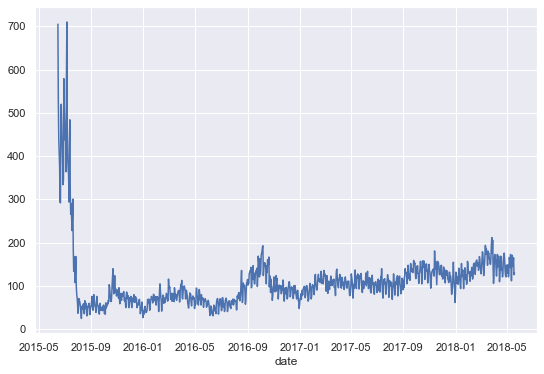

In [44]:
events_data.groupby('date').user_id.nunique().plot();

In [45]:
events_data.pivot_table(index = 'user_id', 
                        columns = 'action', 
                        values = 'step_id', 
                        aggfunc='count',
                        fill_value = 0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


### Submissions Data

In [39]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit = 's')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


In [52]:
submissions_data.date = submissions_data.date.dt.time
submissions_data = submissions_data.rename(columns={'date':'time', 'day':'date'})
submissions_data = submissions_data.reindex(columns = ['step_id', 'submission_status', 'user_id', 'time', 'date', 'timestamp'])

In [53]:
submissions_data.head(3)

,step_id,submission_status,user_id,time,date,timestamp
0,31971,correct,15853,06:21:15,2015-06-15,1434349275
1,31972,correct,15853,06:05:00,2015-06-15,1434348300
2,31972,wrong,15853,08:15:49,2016-11-11,1478852149


In [45]:
users_scores = submissions_data.pivot_table(index = 'user_id', 
                        columns = 'submission_status', 
                        values = 'step_id', 
                        aggfunc='count',
                        fill_value = 0).reset_index().head()

In [55]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


___

In [71]:
gap_data = events_data[['user_id', 'date', 'timestamp']].drop_duplicates(subset = ['user_id', 'date']). \
    groupby('user_id')['timestamp'].apply(list). \
    apply(np.diff).values

In [74]:
gap_data = pd.Series(np.concatenate(gap_data, axis = 0))

In [83]:
gap_data = ( gap_data / (24*60*60) )

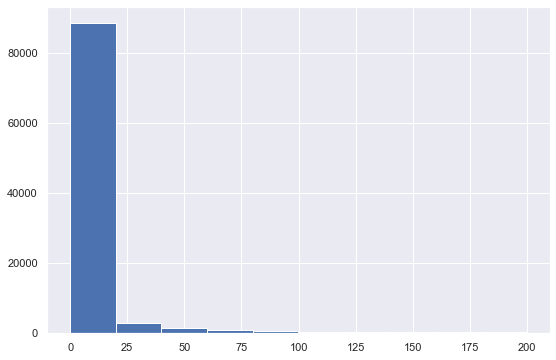

In [85]:
gap_data[gap_data < 200].hist();

In [89]:
gap_data.quantile(0.95)

59.760440972222156

In [92]:
users_scores.sort_index(inplace = True)

In [110]:
np.array(submissions_data[submissions_data.submission_status == 'wrong'].user_id)

array([15853, 15853, 15853, ..., 15253,  1424,  9422])

In [112]:
users_with_no_mistakes = submissions_data[~submissions_data.user_id.isin(submissions_data[submissions_data.submission_status == 'wrong'].user_id)]

In [128]:
pd.DataFrame(users_with_no_mistakes.groupby('user_id').step_id.count()).sort_values(by = ['step_id'], ascending = False)

,step_id
user_id,
5818,65
18782,28
3618,25
10152,25
2654,24
...,...
16239,1
16268,1
9653,1


In [144]:
len(submissions_data.query('user_id == 5818'))

65

In [149]:
submissions_data.head(5)

,step_id,submission_status,user_id,time,date,timestamp
0,31971,correct,15853,06:21:15,2015-06-15,1434349275
1,31972,correct,15853,06:05:00,2015-06-15,1434348300
2,31972,wrong,15853,08:15:49,2016-11-11,1478852149
3,31972,correct,15853,08:16:04,2016-11-11,1478852164
4,31976,wrong,15853,06:02:03,2015-06-15,1434348123


In [4]:
pd.DataFrame(submissions_data.groupby(['user_id', 'submission_status']). \
             step_id.count()).query('submission_status == "correct"'). \
             sort_values(by = 'step_id', ascending = False).head(1)

,,step_id
user_id,submission_status,
1046,correct,421


In [25]:
from datetime import datetime
now = int(datetime(2018,5,20,2,33,31).timestamp())
drop_out_threshold = 30 * 24 * 60 * 60

In [5]:
events_data.tail()

,step_id,timestamp,action,user_id
3480698,33375,1526772685,viewed,11677
3480699,32815,1526772750,viewed,5198
3480700,32815,1526772750,discovered,5198
3480701,32815,1526772750,passed,5198
3480702,33892,1526772811,viewed,18526


In [9]:
users_data = events_data.groupby('user_id', as_index = False). \
    agg({'timestamp':'max'}).rename(columns = {'timestamp':'last_timestamp'})

In [31]:
users_data['user_is_gone'] = (now - users_data.last_timestamp) > drop_out_threshold

In [11]:
users_data.head()

,user_id,last_timestamp,user_is_gone
0,1,1472827464,53945347
1,2,1519226966,7545845
2,3,1444581588,82191223
3,5,1499859939,26912872
4,7,1521634660,5138151


In [30]:
users_data['days_from_gone'] = (users_data.user_is_gone / (24*60*60))

In [42]:
users_data.reset_index(inplace = True)

In [43]:
users_data.head()

,user_id,last_timestamp,user_is_gone,days_from_gone
0,1,1472827464,True,624.367442
1,2,1519226966,True,87.336169
2,3,1444581588,True,951.287303
3,5,1499859939,True,311.491574
4,7,1521634660,True,59.469340


In [50]:
users_data = users_data.merge(users_scores, how = 'outer').fillna(0)

In [51]:
users_data.head()

,user_id,last_timestamp,user_is_gone,days_from_gone,correct,wrong
0,1,1472827464,True,624.367442,0.0,0.0
1,2,1519226966,True,87.336169,2.0,0.0
2,3,1444581588,True,951.287303,29.0,23.0
3,5,1499859939,True,311.491574,2.0,2.0
4,7,1521634660,True,59.469340,0.0,0.0
